# Additive manufacturing example

In [ ]:
!pip install PyAPD -U

In [1]:
# SETUP:

# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

In [2]:
# helper function:
def plot_ellipse(u,v,a,b,t_rot):
# u=1.       #x-position of the center
# v=0.5      #y-position of the center
# a=2.       #radius on the x-axis
# b=1.5      #radius on the y-axis
# t_rot=pi/4 #rotation angle

    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
         #u,v removed to keep the same center location
    R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  
         #2-D rotation matrix

    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    return [u+Ell_rot[0,:] , v+Ell_rot[1,:]]

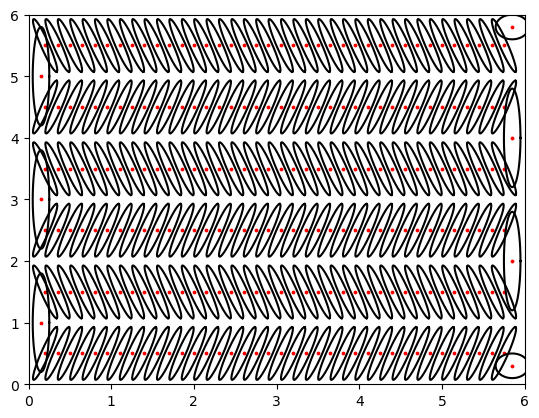

In [3]:
X = np.zeros((0,2))
abt_data = np.zeros((0,4))
for j in range(6):
    for i in range(38):
        X = np.concatenate([X, [[0.15*i+0.2,0.5+j]] ], axis=0)
        aa = 1 if j % 2 == 0 else -1
        abt_data = np.concatenate([abt_data,[[0.45,0.05,aa*np.pi/2.5,np.pi*0.5*0.05]]],axis=0)
        
for j in range(3):
    X = np.concatenate([X,[[0.15,1.0+2*j]] ],axis=0)
    abt_data = np.concatenate([abt_data,[[0.1,0.8,0.0,np.pi*0.5*0.05]]],axis=0)

for j in range(2):
    X = np.concatenate([X,[[6.0-0.15,2.0+2*j]] ],axis=0)
    abt_data = np.concatenate([abt_data,[[0.1,0.8,0.0,np.pi*0.5*0.05]]],axis=0)
    
for j in range(2):
    X = np.concatenate([X,[[6.0-0.15,0.3+5.5*j]] ],axis=0)
    abt_data = np.concatenate([abt_data,[[0.2,0.2,0.0,np.pi*0.3*0.3]]],axis=0)
    
plt.scatter(X[:,0],X[:,1],c='r',s=3)
plt.xlim(0, 6)
plt.ylim(0, 6)
for i in range(len(abt_data)):
    data = plot_ellipse(X[i,0],X[i,1],
                        abt_data[i,0],
                        abt_data[i,1],
                        abt_data[i,2])
    plt.plot(data[0],data[1],c='k')

In [4]:
TV = abt_data[:,-1]
A = np.zeros((0,2,2))
for i in range(len(abt_data)):
    A_new = convert_axes_and_angle_to_matrix_2D(abt_data[i,0],
                                                abt_data[i,1],
                                                abt_data[i,2]).cpu().numpy()
    A = np.concatenate([A,[A_new]],axis=0)

In [5]:
prefactor = max([np.linalg.det(a) for a in A])

In [6]:
seed = 50
N_extra = 300
TV_new = np.array([0.1*TV.min()]*N_extra)
TV = np.append(TV,TV_new)

torch.manual_seed(seed)
X_new = torch.rand(N_extra, 2).cpu().numpy()*6.0
X = np.concatenate([X,X_new],axis=0)

torch.manual_seed(10+seed)
A_new = sample_normalised_spd_matrices(N_extra,dim=2,ani_thres=0.01).cpu().numpy()*(prefactor**(0.5))
A = np.concatenate([A,A_new],axis=0)

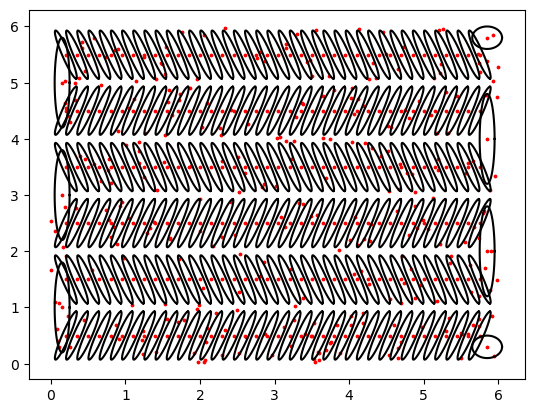

In [7]:
for i in range(len(abt_data)):
    data = plot_ellipse(X[i,0],X[i,1],
                        abt_data[i,0],
                        abt_data[i,1],
                        abt_data[i,2])
    plt.plot(data[0],data[1],c='k')

plt.scatter(X[:,0],X[:,1],c='r',s=3)

In [8]:
assert len(X) == len(A)
assert len(X) == len(TV)

In [9]:
import random
idxs = [i for i in range(len(X))]
random.shuffle(idxs)

In [10]:
X = X[idxs]
A = A[idxs]
TV = TV[idxs]

In [11]:
X = torch.from_numpy(X).to(device,dtype=dt)
A = torch.from_numpy(A).to(device,dtype=dt)
TV = torch.from_numpy(TV).to(device,dtype=dt)
N, D = X.shape

In [12]:
box_size_x = 6.0
box_size_y = 6.0

total_area = TV.sum()
print('Box size in microns =',box_size_x, 'x', box_size_y,'=', box_size_x*box_size_y)
print("Largest grain: ", torch.max(TV).cpu().numpy(), "Smallest grain: ",torch.min(TV).cpu().numpy())

TV = TV*(box_size_x*box_size_y)/total_area
total_area = TV.sum()

Box size in microns = 6.0 x 6.0 = 36.0
Largest grain:  0.2827433388230814 Smallest grain:  0.007853981633974483


In [13]:
# Manually enter the correct domain size:
dom_x = [0.0,6.0]
dom_y = [0.0,6.0]
domain = torch.tensor([dom_x,dom_y])

In [14]:
# Construct an APD system:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 2.0,
                  error_tolerance = 0.01
                  )

In [15]:
apd1.pixel_params

(1038, 1038)

In [16]:
apd1.assemble_pixels()

In [17]:
# Find first optimal set of weights
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001332346, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -57.046114
         Iterations: 102
         Function evaluations: 105
It took 0.6170749664306641 seconds to find optimal W.


In [18]:
# redo to get real runtime:

# Construct an APD system:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 2.0,
                  error_tolerance = 0.01
                  )

apd1.assemble_pixels()

# Find first optimal set of weights
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001332346, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -57.046114
         Iterations: 102
         Function evaluations: 105
It took 0.5839462280273438 seconds to find optimal W.


In [19]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.8130352946418155


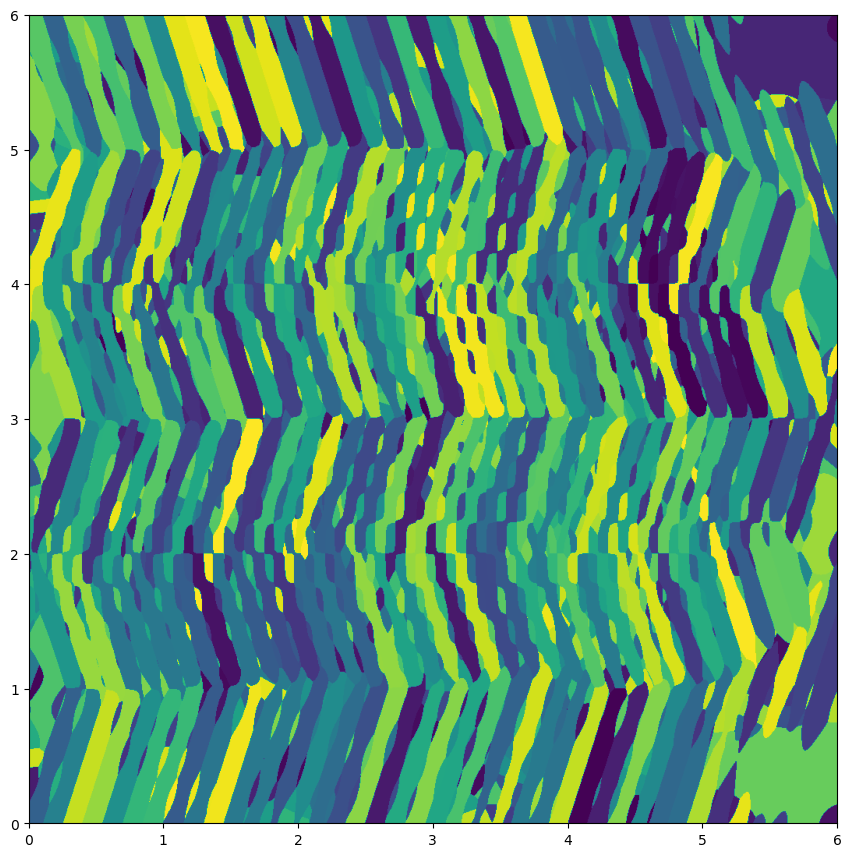

In [20]:
# Plot the resulting APD
fig1, ax1 = apd1.plot_apd()

In [21]:
# Regularise it by running 5 iterations of the Lloyds algorithm
apd1.Lloyds_algorithm(K=5,verbosity_level = 2)

Lloyds iteration: 0
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001332346, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -57.046115
         Iterations: 1
         Function evaluations: 2
It took 0.01601386070251465 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.8130352946418025
Lloyds iteration: 1
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001332346, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -37.930186
         Iterations: 96
         Function evaluations: 99
It took 0.5800440311431885 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.9424155686977884
Lloyds iteration: 2
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001332346, device='cuda:0')
Optim

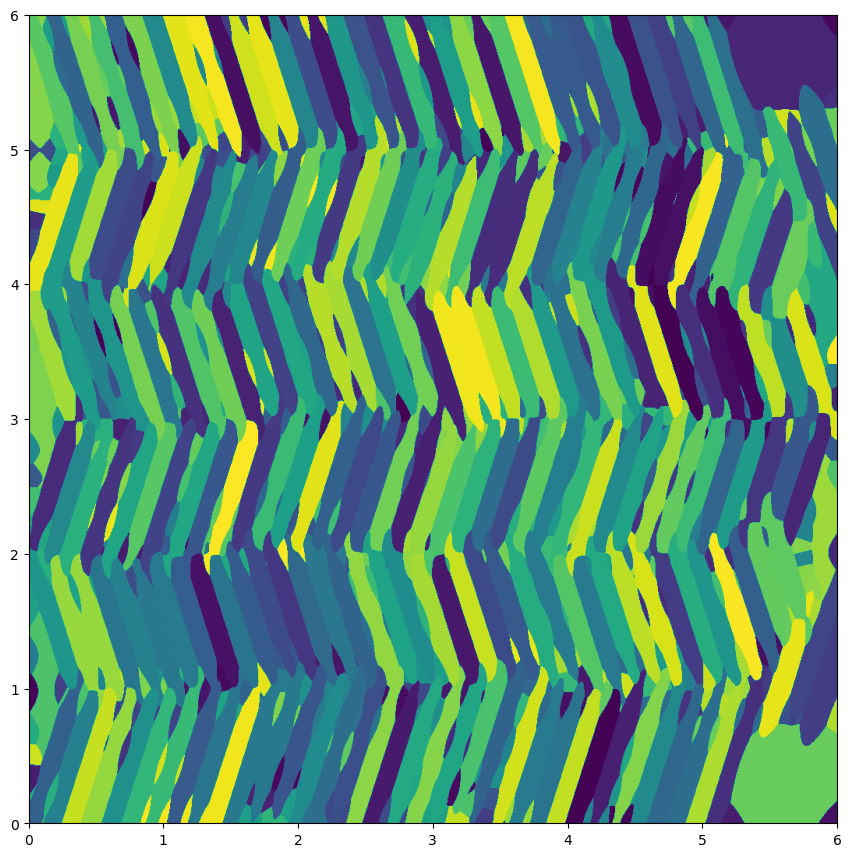

In [22]:
# Plot the resulting APD
fig2, ax2 = apd1.plot_apd()

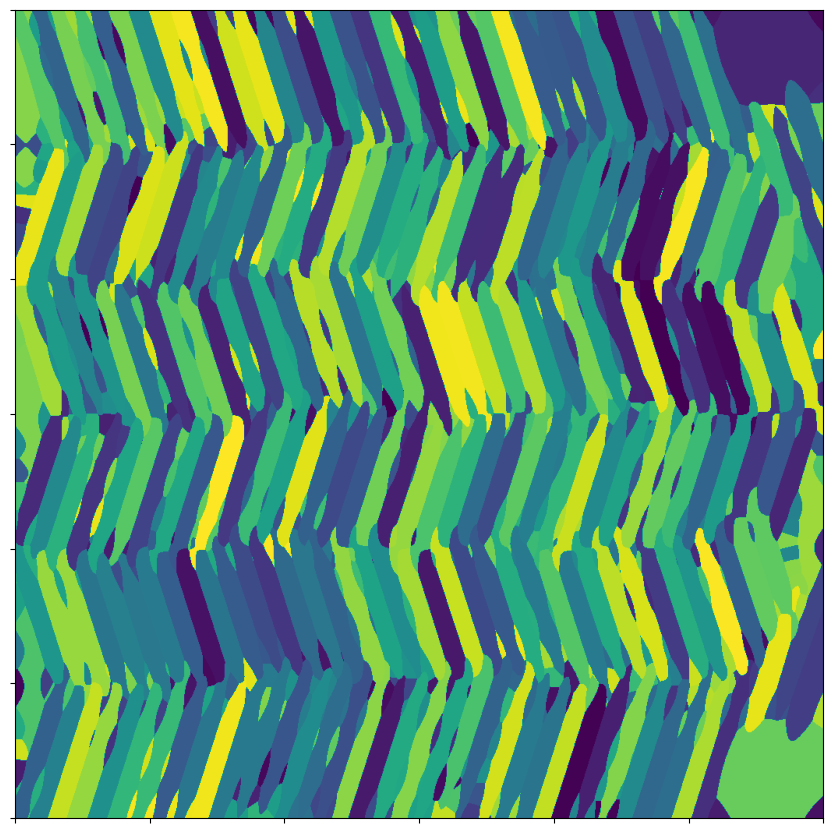

In [23]:
# Save the figure
ax2.set_xticklabels([])
ax2.set_yticklabels([])

fig2.set_size_inches(10.5, 10.5, forward=True)
#fig2.savefig('AM_apd_final.pdf')
fig2